### Model dynamics:
* Consider an option price which evolves according to 
$$ \text{d} S_{t} = \mu S_{t} \text{d}t + \sigma S_{t} \text{d} W_{t} $$ 
* We use an Euler discretization of the form $$ S_{t+h} = S_{t} \text{exp} \left [ \left( \mu - \frac{1}{2} \sigma^{2} \right ) h + \sigma \sqrt{h} Z_{t} \right ], $$ 
for a small $h$, where $Z_{t} \sim \text{N}(0,1)$ and are independent.
$$ \Rightarrow \text{log}(S_{t+h}) \sim \mathcal{N} \left( \text{log}(S_{t}) + \left( \mu - \frac{1}{2} \sigma^{2} \right ) h, \sigma^{2} h \right )  $$
* We consider an Asian Option of the form $ \sum_{i=1}^{m} f(S_{t_{i}}) $ where $0 < t_{1} < \ldots < t_{m} = T $ is a set of montoring dates and $f$ is some function. 
* We want to estimate the price of this option, that is, we want to estimate 
$$ \mathbb{E} \left [ \sum_{i=1}^{m} f(S_{t_{i}}) \right ] = \int \left [ \sum_{i=1}^{m} f(s_{t_{i}}) \right ] p(s_{1:T}|s_{0}) \text{d} s_{1:T} $$
where $s_{0}$ is the price at time $0$.
* For the moment, we assume that $t_{1} = k, t_{2} = 2k, \ldots, t_{m} = mk = N $, that is, we simulate forward one day at a time and look at the price after every $k$ days. 
* Instead of the expectation above, let us (for the time being) target $ \text{E} | \sum_{i=1}^{m} f(S_{t_{i}}) | $
* Henceforth, we change our notation to let $S$ denote the log-price, in which case the distributions become normal instead of lognormal.


### Idea: 
(Everything is conditioned on $s_{0}$)
* The general way of doing SIR would be to first sample from the sequence of densities which are proportional to $$ p(s_{1}), p(s_{1:2}), \ldots, p(s_{1:(k-1)}), |f(s_{k})|^{\kappa_{1}} p(s_{1:k}) $$
$$ p(s_{1:(k+1)}), p(s_{1:(k+2)}), \ldots, p(s_{1:(2k-1)}), |\sum_{i=1}^{2} |f(s_{ik})|^{\kappa_{2}} p(s_{1:2k}) $$
$$ \vdots $$
$$ p(s_{1:(m-1)k+1}), \ldots, p(s_{1:mk-1}), |\sum_{i=1}^{m} f(s_{ik})| ^{\kappa_{m}} p(s_{1:mk}), $$
where $ 0 \leq \kappa_{1} < \ldots < \kappa_{m} < 1 $ and the process densities are used as proposals.
* Given these samples, we use SMC samplers to sample from the sequence of densities
$$ \pi_{n}^{\prime}(s_{1:N}) \propto | \sum_{i=1}^{m} f(s_{ik}) |^{\tilde{\kappa}_{n}} p(s_{1:N}) $$
for $n = 1, 2, \ldots, p$ and $ \kappa_{m} = \tilde{\kappa}_{1} < \ldots < \tilde{\kappa}_{p} = 1 $
* The SIR algorithm is pretty straightforward to apply, but the SMC sampler is more complicated. 

In [1]:
# Calling libraries:

%matplotlib inline  
from __future__ import division
import numpy as np
import time
from scipy.stats import norm, uniform
from pylab import plot, show, legend
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 5.0) #for larger plots

def f(x):
    return x
np.vectorize(f)

### SIR: 

* Since our model is quite simple, what we can do is that we sample from the sequence of densities 
$$ \pi_{n}(s_{t_{1}},\ldots,s_{t_{n}}) \propto |\sum_{i=1}^{n} f(s_{t_{i}}) |^{\kappa_{n}} p(s_{t_{1}},\ldots,s_{t_{n}}) = |\sum_{i=1}^{n} f(s_{ik}) |^{\kappa_{n}} p(s_{k},\ldots,s_{nk}) $$
for $n = 1, \ldots, m$. 
* We can do this because we know the process densities of $S_{k}, S_{2k}, \ldots, S_{mk}$ and we can simulate $S_{0} \rightarrow S_{k} \rightarrow S_{2k} \rightarrow \cdots \rightarrow S_{mk}$ directly without any intermediate points of the path. 
* Henceforth, we refer to these as $S_{1:m}$ for notational convenience.

What are the incremental weights in this case?
* We observe that we are targeting $\gamma_{n}(s_{1:n}) = |\sum_{i=1}^{n}(s_{i})|^{\kappa_{n}} p(s_{1:n}) $ at the $n$-th time step. 
* Our proposals are $q_{n}(s_{1:n}) =$ process density of $S_{1:n}$.
* In this case, the weights are (for $n = 1,2, \ldots, m$): 
$$ w_{n}(s_{1:n}) = \frac{ \gamma_{n}(s_{1:n}) }{ q_{n}(s_{1:n}) } = \frac{ \gamma_{n-1}(s_{1:n-1}) }{ q_{n-1}(s_{1:n-1}) } \times \frac{ \gamma_{n}(s_{1:n})}{ \gamma_{n-1}(s_{1:n-1}) q_{n}(s_{n}|s_{1:n-1})} = w_{n-1}(s_{1:n-1}) \alpha_{n}(s_{1:n}) $$
where 
$$ \alpha_{n}(s_{1:n}) = \frac{ \gamma_{n} (s_{1:n}) } { \gamma_{n-1} (s_{1:n-1}) q_{n}(s_{n}|s_{1:n-1}) } = \frac{ | \sum_{i=1}^{n} f(s_{i}) |^{\kappa_{n}} p(s_{1:n}) } { | \sum_{i=1}^{n-1} f(s_{i}) |^{\kappa_{n-1}} p(s_{1:n-1})} \frac{1}{p(s_{n}|s_{1:n-1}) } = \frac{ | \sum_{i=1}^{n} f(s_{i}) |^{\kappa_{n}} } { | \sum_{i=1}^{n-1} f(s_{i}) |^{\kappa_{n-1}} } $$
where $p(\cdot)$ denotes the process density of the Brownian motion.

A note on the normalizing constant: 
* $Z_{1}^{SIR} = \int p(s_{1}) \text{d} s_{1} = 1$.
* $Z_{m}^{SIR} = \int |\sum_{i=1}^{m} f(s_{i})|^{\kappa_{m}} p(s_{1:m}) \text{d} s_{1:m} $ is the normalizing constant in the SIR algorithm, which we estimate. 

In [2]:
# SIR algorithm: 

def SIR(m,k,S_0,sigma,mu,M,c,kappa):
    
    S = np.zeros((M,m+1))
    S[:,0], weights = [S_0]*M, [1/M]*M
    cut_off, normalizing_constant = M*c, 1.0
    mean, sd = (mu-0.5*sigma**2)*k/360, sigma*np.sqrt(k/360)
    
    S[:,1] = S[:,0] + mean + sd*norm.rvs(0,1,M)
    for n in np.add(2,range(m-1)):                                          # n = 2, 3, ..., m
        weights /= np.power(np.absolute(np.sum(f(S[:,1:n]),axis=1)),kappa[n-2])
        S[:,n] = S[:,n-1] + mean + sd*norm.rvs(0,1,M)
        weights *= np.power(np.absolute(np.sum(f(S[:,1:(n+1)]),axis=1)),kappa[n-1])
        normalizing_constant *= np.sum(weights) 
        weights /= np.sum(weights)
        ESS = 1/np.sum(weights**2)
        if(ESS<cut_off):
            S[:,1:(n+1)] = S[np.random.choice(a=range(M),size=M,p=weights),1:(n+1)]
            weights = [1/M]*M 
        
    return S[:,1:(m+1)], weights, normalizing_constant

##### Sanity check: (is SIR code correct?)
* The normalizing constant in SIR is approximating $ \text{E} |\sum_{i=1}^{m} f(S_{i}) |^{\kappa_{m}} $
* Let us do a naive Monte Carlo to verify that this is working properly.

In [3]:
# Naive Monte Carlo to check if SIR is working okay:

def naive_MC_SIR(m,k,S_0,sigma,mu,M):
    S, f_S = [S_0]*M, np.zeros(M) 
    mean, sd = (mu-0.5*sigma**2)*k/360, sigma*np.sqrt(k/360)
    for i in range(m):                                                   # i = 1, 2, ..., m
        S += mean + sd*norm.rvs(0,1,M)
        f_S += f(S)
    return np.mean(np.power(np.absolute(f_S),kappa[m-1]))

In [4]:
m, k, M = 30, 30, 10**4
kappa = np.linspace(start=0.0,stop=0.5,num=m)
S_0, sigma, mu = np.log(100), 3.0, 0.0
c_SIR = 0.5

SIR(m,k,S_0,sigma,mu,M,c_SIR,kappa)[2], naive_MC_SIR(m,k,S_0,sigma,mu,M)

(7.8591571836403809, 7.8589780772055207)

In [5]:
m, k, M = 15, 60, 10**4
kappa = np.linspace(start=0.0,stop=0.5,num=m)
S_0, sigma, mu = np.log(100), 2.0, 0.0
c_SIR = 0.5

SIR(m,k,S_0,sigma,mu,M,c_SIR,kappa)[2], naive_MC_SIR(m,k,S_0,sigma,mu,M)

(5.4172700394946771, 5.3864759268689131)

* Okay, so SIR seems to be working okay! 
* This took some time to get correct (unfortunately), but at least it works. 
* Is the variance of the SIR estimate less than the variance of the naive MC estimate?

### SMC Sampler:
* Again, we do a simplificaton because the model is simple. 
* What we want to do is to sample from 
$$ \tilde{\pi}_{n} (s_{1:m}) \propto |\sum_{i=1}^{m} f(s_{i}) |^{\tilde{\kappa}_{n}} p(s_{1:m}) $$
for $n = 1, \ldots, p$ and $ \kappa_{m} = \tilde{\kappa}_{1} < \ldots < \tilde{\kappa}_{p} = 1 $
* SIR gives a bunch of particles $\{ s_{1:m}^{(l)} \}_{l=1}^{M}$ with weights $\{ w^{(l)} \}_{l=1}^{M} $.
* Let $x^{(l)} = \{ s_{1:m}^{(l)} \}$, $l = 1, \ldots, M$.

So how do we do SMC sampling? 
* For each particle $x^{(l)}$, we initialize particles $x_{0}^{(l)} = x^{(l)}$ and weights $w_{0}^{(l)} = w^{(l)}$. We do this using the SIR algorithm algorithm. The weights are obtained from the SIR algorithm.
* Move $x_{n-1}^{(l)} \rightarrow x_{n}^{(l)}$ by using kernel $K_{n}(x_{n-1}^{(l)},x_{n})$.
* Compute incremental weights:
$$ W_{n}^{(l)}(x_{(n-1):n}^{(l)}) = \frac{ \tilde{\pi}_{n}(x_{n}^{(l)}) L_{n-1}(x_{n}^{(l)},x_{n-1}^{(l)})}{ \tilde{\pi}_{n-1}(x_{n-1}^{(l)}) K_{n}(x_{n-1}^{(l)},x_{n}^{(l)}) } $$ 
and then resample if need be.
* The choice of backward kernel is:
$$ L_{n-1}(x_{n},x_{n-1}) = \frac{ \tilde{\pi}_{n}(x_{n-1}) K_{n}(x_{n-1},x_{n}) }{ \tilde{\pi}_{n}(x_{n}) }, $$
in which case the incremental weights reduce down to:
$$ W_{n}^{(l)}(x_{n-1}^{(l)}) = \frac{\tilde{\pi}_{n}(x_{n-1}^{(l)})}{\tilde{\pi}_{n-1}(x_{n-1}^{(l)})} = \frac{ | \sum_{i=1}^{m} f(s_{i,n-1}^{(l)}) |^{\tilde{\kappa}_{n}} } { | \sum_{i=1}^{m} f(s_{i,n-1}^{(l)}) |^{\tilde{\kappa}_{n-1}} }, \text{ } n \geq 1, $$
where $ x_{n}^{(l)} = s_{1:m,n}^{(l)}$, $n = 1, 2, \ldots, p$ and $l = 1, 2, \ldots, M$.

* What is $ \tilde{\pi}_{0}(x_{0}^{(l)})$? These are (from the SIR model): 
$$\pi_{m}(s^{(l)}_{1:m}) \propto | \sum_{i=1}^{m} f(s^{(l)}_{i}) |^{\kappa_{m}} p(s^{(l)}_{1:m}) = \tilde{\pi}_{n} (s^{(l)}_{1:m})$$ 
as $\tilde{\kappa}_{n} = \kappa_{m} $.

The question that remains is how to choose the kernel $K_{n}$?
* We want $K_{n}(x_{n-1},\cdot)$ to be $\tilde{\pi}_{n}(\cdot)$ invariant.
* The simplest way to do this is to do a symmetric Metropolis-Hastings random walk.
* Therefore, propose $S_{n} \sim \text{N}(x_{n-1},\text{I})$ and accept with probability 
$$1 \wedge \frac{\tilde{\pi}_{n}(X_{n})}{\tilde{\pi}_{n}(s_{n-1})} = 1 \wedge \frac{|\sum_{i=1}^{m}f(S_{i})|^{\tilde{\kappa}_{n}} p(S_{1:m})}{ |\sum_{i=1}^{m}f(s_{i})|^{\tilde{\kappa}_{n}} p(s_{1:m}) } $$

A note on the normalizing constant:
* $Z_{1}^{SMC} = \int | \sum_{i=1}^{m} f(s_{i}) |^{\tilde{\kappa}_{1}} p(s_{1:m}) \text{d} s_{1:m} = Z_{m}^{SIR}$ as $\tilde{\kappa}_{1} = \kappa_{m}$.
* $ Z_{p}^{SMC} = \int | \sum_{i=1}^{m} f(s_{i}) | p(s_{1:m}) \text{d} s_{1:m} $ is the normalizing constant in the SMC algorithm, and is precisely what we want to estimate.

In [6]:
# SMC samplers: 
# We work on a log scale for densities because they tend to be tiny.
# p(s_{1:m}): 
# This is the density of the path of a Brownian Motion starting at S_0
# ('path' does not contain S_0)
# We consider the log of the density

def log_path_density(sigma,mu,s_0,path):
    path = np.append(s_0,path)
    N = np.size(path)
    mean = path[0:(N-1)] + (mu-0.5*sigma**2)*k/360.0
    sd = sigma*np.sqrt(k/360.0)
    return np.sum(np.log(norm.pdf(path[1:N],loc=mean,scale=sd)))
np.vectorize(log_path_density)

In [7]:
# Symmetric random walk Metropolis-Hastings kernel:
# (No new array created)
def propagate(original,proposed,n):
    proposed = norm.rvs(loc=original,scale=1.0) 
    a = np.power(np.absolute(np.sum(f(proposed))/np.sum(f(original))),kappa_tilde[n])
    b = np.exp(log_path_density(sigma,mu,S_0,proposed)-log_path_density(sigma,mu,S_0,original))
    MH_ratio = a*b
    acceptance_probability = 1.0
    if(MH_ratio<1.0):
        acceptance_probability = MH_ratio
    u = uniform.rvs(size=1)
    if(u<acceptance_probability):
        original = proposed
    return original

In [8]:
# Defining the SMC function:

def SMC(m,k,S_0,sigma,mu,M,c_SIR,c_SMC,kappa,kappa_tilde):
    
    # We first run SIR with M particles:
    S, weights, SIR_normalizing_constant = SIR(m,k,S_0,sigma,mu,M,c_SIR,kappa)
    
    # Next define some necessary things:
    cut_off, normalizing_constant = c_SMC*M, SIR_normalizing_constant
    incremental_weights, proposed = np.zeros(M), np.zeros(M)
    p = np.size(kappa_tilde)-1

    for n in np.add(1,range(p)):                                              # n = 1, 2, ..., p
        # Propagating and computing incremental weights:
        # (hopefully we shall later be able to do without the loop over i)
        for i in range(M):                                                              
            incremental_weights[i] = np.power(np.absolute(np.sum(f(S[i,:]))),kappa_tilde[n]-kappa_tilde[n-1])
            S[i,:] = propagate(S[i,:],proposed,n)
        weights *= incremental_weights
        normalizing_constant *= np.sum(weights) 
        weights /= np.sum(weights)
        ESS = 1/np.sum(weights**2)
        if(ESS<cut_off):
            S = S[np.random.choice(a=range(M),size=M,p=weights),:]
            weights = [1/M]*M 
        
    return normalizing_constant 

### Naive Monte Carlo: 
* As a comparison, we can also use naive Monte Carlo to estimate the price. 
* We simulate a bunch of $M$ paths of the process independently of each other and then estimate the option price as 
$$ \frac{1}{M} \sum_{l=1}^{M} \left [ \sum_{i=1}^{m} f(S_{i}^{(l)}) \right ] $$
where we again use the simplification $S_{1:m}$ for $S_{t_{1}:t_{m}}$ nd where $S_{1:m}^{(l)}$ denotes the $l$-th path.
* However, since the SMC algorithm is essentially approximating $ \text{E} | \sum_{i=1}^{m} f(S_{i}) | $, let us also use naive Monte Carlo to estimate the same quantity. 

In [9]:
# Naive Monte Carlo

def naive_MC(m,k,S_0,sigma,mu,M):
    m = np.int(m)
    price = np.zeros(M)
    S = [S_0]*M 
    mean = [(mu - 0.5*sigma**2)*k/360.0]*M
    sd = sigma*np.sqrt(k/360.0)
    for i in np.add(1,range(m)):                                                    # i = 1, 2, ..., m
        S = np.add(S,mean+sd*norm.rvs(0,1,M))
        price += f(S)
    return np.mean(np.absolute(price)) 

##### Another sanity check (is the code for the SMC sampler correct?):

In [11]:
m, k, M, p = 20, 30, 10**4, 15
kappa = np.linspace(start=0.0,stop=0.5,num=m)
kappa_tilde = np.linspace(start=0.5,stop=1.0,num=p)
S_0, sigma, mu = np.log(100), 3.0, 0.0
c_SIR, c_SMC = 0.5, 0.5

print "kappa =", kappa
print "kappa_tilde =", kappa_tilde

SMC(m,k,S_0,sigma,mu,M,c_SIR,c_SMC,kappa,kappa_tilde), naive_MC(m,k,S_0,sigma,mu,M)

kappa = [ 0.          0.02631579  0.05263158  0.07894737  0.10526316  0.13157895
  0.15789474  0.18421053  0.21052632  0.23684211  0.26315789  0.28947368
  0.31578947  0.34210526  0.36842105  0.39473684  0.42105263  0.44736842
  0.47368421  0.5       ]
kappa_tilde = [ 0.5         0.53571429  0.57142857  0.60714286  0.64285714  0.67857143
  0.71428571  0.75        0.78571429  0.82142857  0.85714286  0.89285714
  0.92857143  0.96428571  1.        ]


(38.433763162998709, 38.294483153781805)

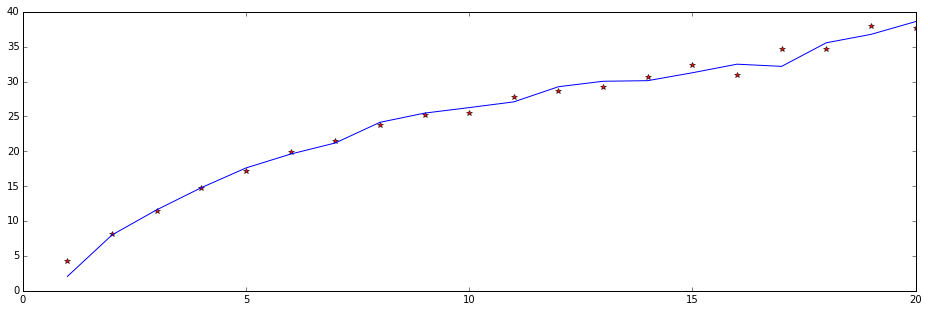

In [12]:
m, k, M, p = 20.0, 30, 10**3, 15
m = np.int(m)

survival_probability_naive_MC = np.zeros(m)
survival_probability_SMC = np.zeros(m)
naive_MC_price = np.zeros(m)
SMC_sampler_price = np.zeros(m)

kappa_tilde = np.linspace(start=0.5,stop=1.0,num=p)

for t in np.add(1,range(m)):                              # t = 1, 2, ..., m
    kappa = np.linspace(start=0.0,stop=0.5,num=t)
    naive_MC_price[t-1] = naive_MC(t,k,S_0,sigma,mu,M)
    SMC_sampler_price[t-1] = SMC(t,k,S_0,sigma,mu,M,c_SIR,c_SMC,kappa,kappa_tilde)
    
plt.figure()
plt.plot(np.add(1,range(m)),naive_MC_price,"r*",np.add(1,range(m)),SMC_sampler_price,"b-")
plt.show()

* The code is working. 

### Basic comparison study: 
* We now look at the standard errors for the naive MC estimate and the SMC estimate. 

In [13]:
rep = 50
SMC_estimate = np.zeros(rep)
MC_estimate = np.zeros(rep)

overall_start_time = time.clock()
start_time = time.clock()
for r in range(rep):
    SMC_estimate[r] = SMC(m,k,S_0,sigma,mu,10**3,c_SIR,c_SMC,kappa,kappa_tilde)
average_SMC_run_time = (time.clock() - start_time)/rep
start_time = time.clock()
for r in range(rep):
    MC_estimate[r] = naive_MC(m,k,S_0,sigma,mu,10**4) 
average_MC_run_time = (time.clock() - start_time)/rep
overall_run_time = time.clock() - overall_start_time

print "SMC estimate =", round(np.mean(SMC_estimate),3)
print "MC estimate =", round(np.mean(MC_estimate),3)
print "SMC standard deviation =", round(np.std(SMC_estimate),3)
print "MC standard deviation =", round(np.std(MC_estimate),3)
print "SMC average run time =", round(average_SMC_run_time,3), "seconds"
print "MC average run time =", round(average_MC_run_time,3), "seconds"
print "Overall run time for", rep, "repetitions =", round(overall_run_time/60,3), "minutes"

SMC estimate = 38.452
MC estimate = 38.462
SMC standard deviation = 0.929
MC standard deviation = 0.238
SMC average run time = 3.094 seconds
MC average run time = 0.013 seconds
Overall run time for 50 repetitions = 2.589 minutes
